## Importing the relevant libraries

In [1]:
# connect to google colab
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# import all the necessary model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import math

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Activation, Dropout, Lambda, Input, GlobalAveragePooling2D, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
# from keras import regularizers
from tensorflow.keras.models import Model, load_model

from IPython.display import display, Image
import time

#from tensorflow.keras.applications import Xception

In [3]:
# change colab flag to false if train using jupyter notebook
COLAB_FLAG = True

COLAB_FILEPATH = './drive/My Drive/4041-dog-breed-classification/' if COLAB_FLAG == True else './'
%matplotlib inline

In [4]:
# checking if GPU is being used for training
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("GPU is not detected")

Default GPU Device:/device:GPU:0


## Import the numpy (.npz) file consisting our training images
* [np.save()](https://numpy.org/doc/stable/reference/generated/numpy.save.html)
* [np.savez()](https://numpy.org/doc/stable/reference/generated/numpy.savez.html)
* [np.savez_compressed()](https://numpy.org/doc/stable/reference/generated/numpy.savez_compressed.html)
* [np.lib.format](https://numpy.org/doc/stable/reference/generated/numpy.lib.format.html)

In [5]:
INPUT_SHAPE = (128,128,3)
NPZ_PATH = f'{COLAB_FILEPATH}Datasets/preprocessed_data_{INPUT_SHAPE[0]}x{INPUT_SHAPE[1]}.npz'

In [6]:
# loading the npz file
print("Loading from npz file")
t = time.time()
loaded = np.load(NPZ_PATH)
print(loaded.files)
loaded_X = loaded["X"]
loaded_Y = loaded["Y"]
print(f'Time taken to load compressed data: {time.time()-t}')

Loading from npz file
['X', 'Y']
Time taken to load compressed data: 11.700915098190308


In [7]:
# check the numpy array information and the size conversion
def convert_size(size_bytes):
    if size_bytes == 0:
        return "0B"
    size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
    i = int(math.floor(math.log(size_bytes, 1024)))
    p = math.pow(1024, i)
    s = round(size_bytes / p, 2)
    return "%s %s" % (s, size_name[i])

def nparray_info(header, nparr):
    print(header)
    print("-  shape\t", nparr.shape)
    print("-  dtype\t", nparr.dtype)
    print("- nbytes\t", f"{nparr.nbytes} ({convert_size(nparr.nbytes)})")

In [8]:
# print out shape, dtype and data size
nparray_info("Images (npz)", loaded_X)
print()
nparray_info("Labels (npz)", loaded_Y)

Images (npz)
-  shape	 (10222, 128, 128, 3)
-  dtype	 float16
- nbytes	 1004863488 (958.31 MB)

Labels (npz)
-  shape	 (10222, 120)
-  dtype	 uint8
- nbytes	 1226640 (1.17 MB)


In [9]:
# check the numpy array values whether is it normalised or not
loaded_X[50][0][:7]

array([[0.6157, 0.565 , 0.498 ],
       [0.4158, 0.3647, 0.298 ],
       [0.306 , 0.251 , 0.2079],
       [0.2354, 0.1843, 0.149 ],
       [0.2313, 0.1804, 0.1569],
       [0.4158, 0.3608, 0.349 ],
       [0.2313, 0.204 , 0.1726]], dtype=float16)

In [10]:
loaded_Y[50]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [16]:
# get the respective labels
# loading labels from csv file
df = pd.read_csv(f"{COLAB_FILEPATH}Datasets/labels.csv")

# create dictionary of unique breeds with its respective id
breeds = sorted(df.breed.unique())
dict_breeds = dict(zip(breeds, range(len(breeds))))

# add duplicate column
df["breed_id"] = df.breed
# convert duplicated column as unique id
df = df.replace({"breed_id":dict_breeds})

print("Shape\t\t: {}".format(df.shape))
print("Unique labels\t: {}".format(len(breeds)))

Shape		: (10222, 3)
Unique labels	: 120


In [17]:
dict_breeds

{'affenpinscher': 0,
 'afghan_hound': 1,
 'african_hunting_dog': 2,
 'airedale': 3,
 'american_staffordshire_terrier': 4,
 'appenzeller': 5,
 'australian_terrier': 6,
 'basenji': 7,
 'basset': 8,
 'beagle': 9,
 'bedlington_terrier': 10,
 'bernese_mountain_dog': 11,
 'black-and-tan_coonhound': 12,
 'blenheim_spaniel': 13,
 'bloodhound': 14,
 'bluetick': 15,
 'border_collie': 16,
 'border_terrier': 17,
 'borzoi': 18,
 'boston_bull': 19,
 'bouvier_des_flandres': 20,
 'boxer': 21,
 'brabancon_griffon': 22,
 'briard': 23,
 'brittany_spaniel': 24,
 'bull_mastiff': 25,
 'cairn': 26,
 'cardigan': 27,
 'chesapeake_bay_retriever': 28,
 'chihuahua': 29,
 'chow': 30,
 'clumber': 31,
 'cocker_spaniel': 32,
 'collie': 33,
 'curly-coated_retriever': 34,
 'dandie_dinmont': 35,
 'dhole': 36,
 'dingo': 37,
 'doberman': 38,
 'english_foxhound': 39,
 'english_setter': 40,
 'english_springer': 41,
 'entlebucher': 42,
 'eskimo_dog': 43,
 'flat-coated_retriever': 44,
 'french_bulldog': 45,
 'german_shepherd'

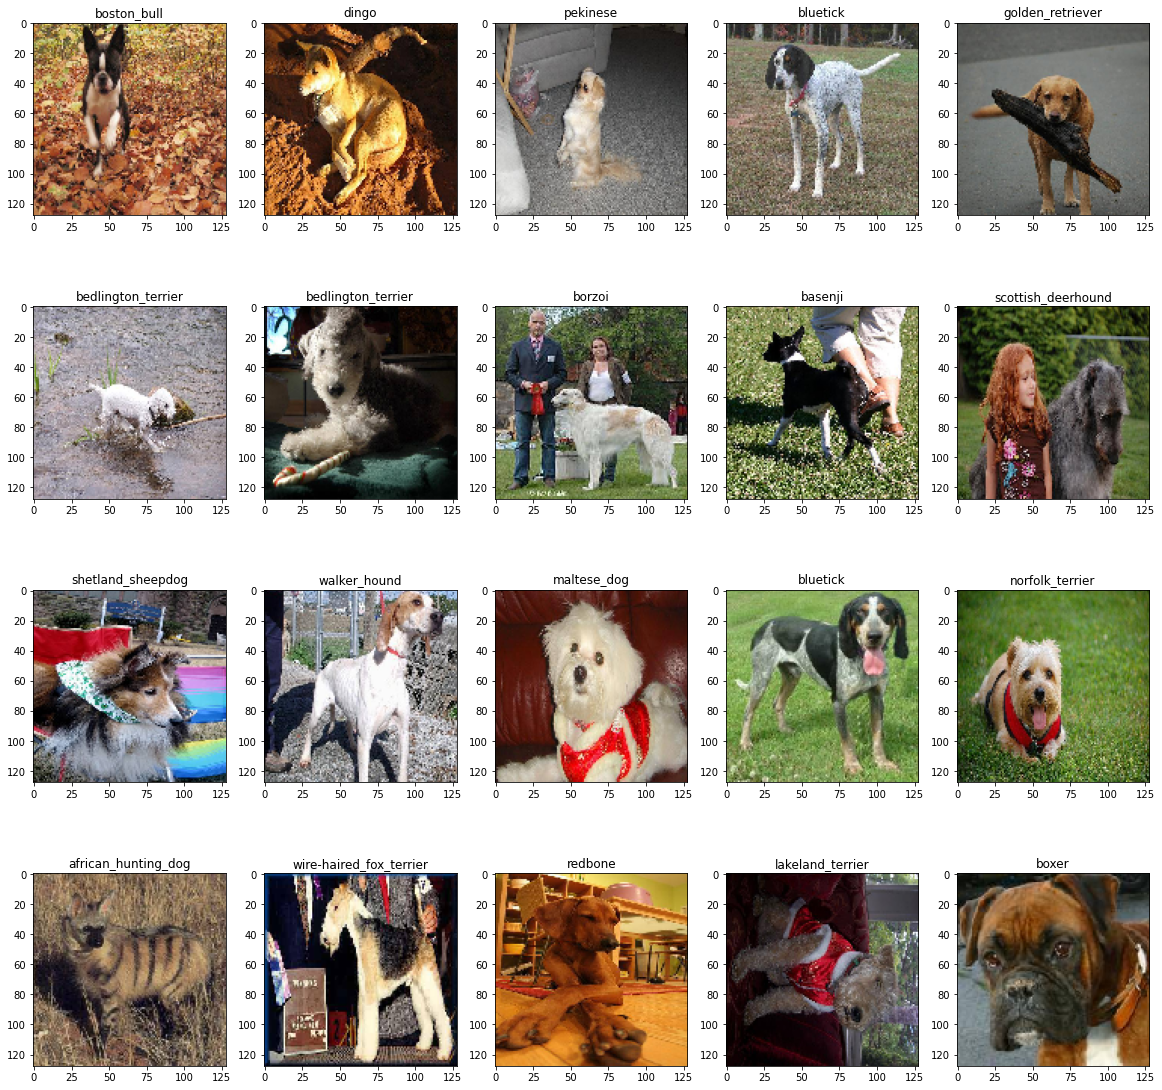

In [18]:
# check the data
N = 20

plt.figure(figsize=(20,20))
for i in range(N):
    ax = plt.subplot(int(N/5),5,i+1)
    plt.title(breeds[np.where(loaded_Y[i]==1)[0][0]])
    plt.imshow(loaded_X[i].astype('float32'))

## Split data into train and val

In [19]:
# perform train test split to get training and validation data
X_train, X_val, y_train, y_val = train_test_split(loaded_X, loaded_Y, train_size=0.8,random_state=42)

## Image Augmentation

In [20]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode = "nearest"
)

# --- MODEL BUILDING ---

### Helper Function

In [21]:
# for plotting
def plot_model_history(history, folder=COLAB_FILEPATH+"plots/", saving_name="model_loss_accuracy"):
    plt.style.use("ggplot")
    plt.figure(figsize=(16, 6))

    # plot for loss
    ax = plt.subplot(1, 2, 1)
    # ensure ploting never plot beyond 10
    #y_max = (max(history.history["loss"]), max(history.history["val_loss"]))
    #y_max = min(10.0, max(y_max))
    #ax.set_ylim(ymax=y_max)
    plt.plot( history.history["loss"], label="train_loss")
    plt.plot( history.history["val_loss"], label="val_loss")

    plt.title(f"Model Loss - {saving_name}")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")

    # plot for accuracy
    ax = plt.subplot(1, 2, 2)
    ax.set_ylim([0,1]) # fix y-range for eazy comparison 
    plt.plot(history.history["accuracy"], label="train_acc")
    plt.plot(history.history["val_accuracy"], label="val_acc")

    plt.title(f"Model Accuracy - {saving_name}")
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")
    plt.legend(loc="upper left")

    # save plot to disk
    os.makedirs(os.path.dirname(folder), exist_ok=True)
    plt.savefig(folder+saving_name+'.jpg')
    plt.show()

def plot_learning_rate(history, folder="plots/", saving_name="model_learn_rate"):
    # history only contain lr when lrScheduler used 
    #assert('lr' in history.history.keys()), "model history does not contain lr, ensure lr related callback is used"
    
    # the learning rate schedule
    plt.style.use("ggplot")
    plt.figure(figsize=(8, 6))
    plt.plot( history.history["lr"], label="learn rate")
    plt.title("Learning Rate")
    plt.xlabel("Epoch #")
    plt.ylabel("Learning Rate")
    # save plot to disk
    os.makedirs(os.path.dirname(folder), exist_ok=True)
    plt.savefig(folder+saving_name)
    plt.show()

In [22]:
# function to train the model
def train_model(model_name,pre_trained_model,batch_size,epochs,lr,optimizer,input_shape=INPUT_SHAPE,Xtrain=X_train,Xval=X_val,ytrain=y_train,yval=y_val):
    # initialise saved weights filename
    filename = f'{model_name}_{input_shape[0]}x{input_shape[1]}_bs-{batch_size}_lr-{lr}_ep-{epochs}'

    # define callbacks
    saved_weights = ModelCheckpoint(filepath=f'{COLAB_FILEPATH}models/{filename}.h5',save_best_only=True,verbose=1)
    reduced_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5, min_lr=1e-6, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # retrieve base model
    base = pre_trained_model

    # freeze pre-trained weight
    # base.trainable = False

    # rebuild output layer
    x = base.output
    x = GlobalAveragePooling2D()(x)
    head = Dense(120, activation='softmax')(x)
    model = Model(inputs=base.input, outputs=head)
    #model.summary()

    # Compiling the model
    model.compile(optimizer=optimizer, 
                  loss = 'categorical_crossentropy', 
                  metrics=['accuracy'])
    
    # train model
    H = model.fit(train_datagen.flow(Xtrain,ytrain,
                                    batch_size=batch_size,
                                    shuffle=True),
                  epochs=epochs,
                  steps_per_epoch=Xtrain.shape[0]//batch_size,
                  validation_data=(Xval,yval),
                  callbacks=[saved_weights, reduced_lr, early_stopping]
              )
    
    return H, filename

In [23]:
# load the different pre-trained models
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.applications import ResNet50, ResNet101, ResNet152, ResNet50V2, ResNet101V2, ResNet152V2
from tensorflow.keras.applications import InceptionV3, InceptionResNetV2
from tensorflow.keras.applications import MobileNet, MobileNetV2
from tensorflow.keras.applications import DenseNet121, DenseNet169, DenseNet201
from tensorflow.keras.applications import NASNetMobile, NASNetLarge

In [24]:
# define dictionary of evaluating models
models = {
    # change here to evaluate other models
    "DenseNet121": DenseNet121(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE),
    "DenseNet169": DenseNet169(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE),
    "DenseNet201": DenseNet201(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE),
    "Xception": Xception(include_top=False,weights="imagenet", input_shape=INPUT_SHAPE),
    "VGG16": VGG16(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE),
    "VGG19": VGG19(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE),
    "ResNet50": ResNet50(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE),
    "ResNet101": ResNet101(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE),
    "ResNet152": ResNet152(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE),
    "ResNet50V2": ResNet50V2(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE),
    "ResNet101V2": ResNet101V2(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE),
    "ResNet152V2": ResNet152V2(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE),
    "InceptionV3": InceptionV3(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE),
    "InceptionResNetV2": InceptionResNetV2(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE),
    "MobileNet": MobileNet(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE),
    "MobileNetV2": MobileNetV2(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
}

In [25]:
# get a list of dictionary keys
models_list = list(models)
# check the value
models_list[0]

'DenseNet121'

# ------ TRAINING OF MODELS ------
#### ------ EXAMPLE OF THE TRAINING WITH 3 EPOCHS ------

In [26]:
# hyperparameters configuration
BATCH_SIZE = 128
EPOCHS = 3
ALPHA = 0.001
OPTIMIZER = Adam(lr=ALPHA, beta_1=0.9, beta_2=0.999)

In [27]:
# DenseNet121
H, filename = train_model(model_name=models_list[0],
                          pre_trained_model=models[models_list[0]],
                          batch_size=BATCH_SIZE,
                          epochs=EPOCHS,
                          lr=ALPHA,
                          optimizer=OPTIMIZER)

Epoch 1/3
63/63 [==============================] - 90s 1s/step - loss: 4.0174 - accuracy: 0.1542 - val_loss: 4.7429 - val_accuracy: 0.0866

Epoch 00001: val_loss improved from inf to 4.74290, saving model to ./drive/My Drive/4041-dog-breed-classification/models/DenseNet121_128x128_bs-128_lr-0.001_ep-3.h5
Epoch 2/3
63/63 [==============================] - 61s 956ms/step - loss: 1.9028 - accuracy: 0.4800 - val_loss: 5.1242 - val_accuracy: 0.1095

Epoch 00002: val_loss did not improve from 4.74290
Epoch 3/3
63/63 [==============================] - 61s 956ms/step - loss: 1.3172 - accuracy: 0.6291 - val_loss: 3.6832 - val_accuracy: 0.1853

Epoch 00003: val_loss improved from 4.74290 to 3.68324, saving model to ./drive/My Drive/4041-dog-breed-classification/models/DenseNet121_128x128_bs-128_lr-0.001_ep-3.h5


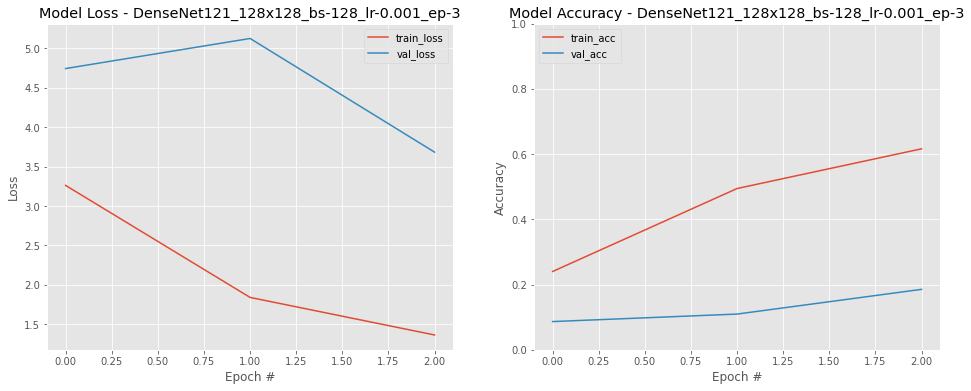

In [28]:
# plot model performance
plot_model_history(H, saving_name=filename)

### ----- ACTUAL TRAINING -----
#### ----- WITH 50 EPOCHS -----

In [29]:
# hyperparameters configuration
BATCH_SIZE = 128
EPOCHS = 50
ALPHA = 0.001
OPTIMIZER = Adam(lr=ALPHA, beta_1=0.9, beta_2=0.999)

In [ ]:
# DenseNet121
H, filename = train_model(model_name=models_list[0],
                          pre_trained_model=models[models_list[0]],
                          batch_size=BATCH_SIZE,
                          epochs=EPOCHS,
                          lr=ALPHA,
                          optimizer=OPTIMIZER)
# plot model performance
plot_model_history(H, saving_name=filename)

In [ ]:
# DenseNet169
H, filename = train_model(model_name=models_list[1],
                          pre_trained_model=models[models_list[1]],
                          batch_size=BATCH_SIZE,
                          epochs=EPOCHS,
                          lr=ALPHA,
                          optimizer=OPTIMIZER)
# plot model performance
plot_model_history(H, saving_name=filename)

In [ ]:
# DenseNet201
H, filename = train_model(model_name=models_list[2],
                          pre_trained_model=models[models_list[2]],
                          batch_size=BATCH_SIZE,
                          epochs=EPOCHS,
                          lr=ALPHA,
                          optimizer=OPTIMIZER)
# plot model performance
plot_model_history(H, saving_name=filename)

In [ ]:
# Xception
H, filename = train_model(model_name=models_list[3],
                          pre_trained_model=models[models_list[3]],
                          batch_size=BATCH_SIZE,
                          epochs=EPOCHS,
                          lr=ALPHA,
                          optimizer=OPTIMIZER)
# plot model performance
plot_model_history(H, saving_name=filename)

In [ ]:
# VGG16
H, filename = train_model(model_name=models_list[4],
                          pre_trained_model=models[models_list[4]],
                          batch_size=BATCH_SIZE,
                          epochs=EPOCHS,
                          lr=ALPHA,
                          optimizer=OPTIMIZER)
# plot model performance
plot_model_history(H, saving_name=filename)

In [ ]:
# VGG19
H, filename = train_model(model_name=models_list[5],
                          pre_trained_model=models[models_list[5]],
                          batch_size=BATCH_SIZE,
                          epochs=EPOCHS,
                          lr=ALPHA,
                          optimizer=OPTIMIZER)
# plot model performance
plot_model_history(H, saving_name=filename)

In [ ]:
# ResNet50
H, filename = train_model(model_name=models_list[6],
                          pre_trained_model=models[models_list[6]],
                          batch_size=BATCH_SIZE,
                          epochs=EPOCHS,
                          lr=ALPHA,
                          optimizer=OPTIMIZER)
# plot model performance
plot_model_history(H, saving_name=filename)

In [ ]:
# ResNet101
H, filename = train_model(model_name=models_list[7],
                          pre_trained_model=models[models_list[7]],
                          batch_size=BATCH_SIZE,
                          epochs=EPOCHS,
                          lr=ALPHA,
                          optimizer=OPTIMIZER)
# plot model performance
plot_model_history(H, saving_name=filename)

In [ ]:
# ResNet152
H, filename = train_model(model_name=models_list[8],
                          pre_trained_model=models[models_list[8]],
                          batch_size=BATCH_SIZE,
                          epochs=EPOCHS,
                          lr=ALPHA,
                          optimizer=OPTIMIZER)
# plot model performance
plot_model_history(H, saving_name=filename)

In [ ]:
# ResNet50V2
H, filename = train_model(model_name=models_list[9],
                          pre_trained_model=models[models_list[9]],
                          batch_size=BATCH_SIZE,
                          epochs=EPOCHS,
                          lr=ALPHA,
                          optimizer=OPTIMIZER)
# plot model performance
plot_model_history(H, saving_name=filename)

In [ ]:
# ResNet101V2
H, filename = train_model(model_name=models_list[10],
                          pre_trained_model=models[models_list[10]],
                          batch_size=BATCH_SIZE,
                          epochs=EPOCHS,
                          lr=ALPHA,
                          optimizer=OPTIMIZER)
# plot model performance
plot_model_history(H, saving_name=filename)

In [ ]:
# ResNet152V2
H, filename = train_model(model_name=models_list[11],
                          pre_trained_model=models[models_list[11]],
                          batch_size=BATCH_SIZE,
                          epochs=EPOCHS,
                          lr=ALPHA,
                          optimizer=OPTIMIZER)
# plot model performance
plot_model_history(H, saving_name=filename)

In [ ]:
# InceptionV3
H, filename = train_model(model_name=models_list[12],
                          pre_trained_model=models[models_list[12]],
                          batch_size=BATCH_SIZE,
                          epochs=EPOCHS,
                          lr=ALPHA,
                          optimizer=OPTIMIZER)
# plot model performance
plot_model_history(H, saving_name=filename)

In [ ]:
# InceptionResNetV2
H, filename = train_model(model_name=models_list[13],
                          pre_trained_model=models[models_list[13]],
                          batch_size=BATCH_SIZE,
                          epochs=EPOCHS,
                          lr=ALPHA,
                          optimizer=OPTIMIZER)
# plot model performance
plot_model_history(H, saving_name=filename)

In [ ]:
# MobileNet
H, filename = train_model(model_name=models_list[14],
                          pre_trained_model=models[models_list[14]],
                          batch_size=BATCH_SIZE,
                          epochs=EPOCHS,
                          lr=ALPHA,
                          optimizer=OPTIMIZER)
# plot model performance
plot_model_history(H, saving_name=filename)

In [ ]:
# MobileNetV2
H, filename = train_model(model_name=models_list[15],
                          pre_trained_model=models[models_list[15]],
                          batch_size=BATCH_SIZE,
                          epochs=EPOCHS,
                          lr=ALPHA,
                          optimizer=OPTIMIZER)
# plot model performance
plot_model_history(H, saving_name=filename)

# --- TRAINING ENDS ---

## ------ LOAD SAVED MODEL ------
Load the model that gives the best validation accuracy

In [30]:
# model configuration
pre_trained_name = 'DenseNet121'
load_input_shape = f'{INPUT_SHAPE[0]}x{INPUT_SHAPE[1]}'
load_bs = 128
load_lr = 0.001
load_ep = 3

In [31]:
# DenseNet121
SAVED_MODEL = f'models/{pre_trained_name}_{load_input_shape}_bs-{load_bs}_lr-{load_lr}_ep-{load_ep}.h5'
model = load_model(f'{COLAB_FILEPATH}{SAVED_MODEL}', compile=False)

## ------ LOAD PRE-PROCESSED TEST DATA ------

In [32]:
NPZ_PATH_TEST = f'{COLAB_FILEPATH}Datasets/preprocessed_data_test_{INPUT_SHAPE[0]}x{INPUT_SHAPE[1]}.npz'

In [33]:
# loading the npz file
print("Loading from npz file")
t = time.time()
loaded = np.load(NPZ_PATH_TEST)
print(loaded.files)
loaded_X_test = loaded["X"]
print(f'Time taken to load compressed data: {time.time()-t}')

Loading from npz file
['X']
Time taken to load compressed data: 14.596900939941406


In [34]:
# print out shape, dtype and data size
nparray_info("Images (npz)", loaded_X_test)

Images (npz)
-  shape	 (10357, 128, 128, 3)
-  dtype	 float16
- nbytes	 1018134528 (970.97 MB)


In [35]:
# check the numpy array values whether is it normalised or not
loaded_X_test[50][0][:7]

array([[0.153 , 0.153 , 0.153 ],
       [0.0745, 0.0745, 0.0745],
       [0.1059, 0.1059, 0.1059],
       [0.0902, 0.0902, 0.0902],
       [0.098 , 0.098 , 0.098 ],
       [0.0902, 0.0902, 0.0902],
       [0.1137, 0.1137, 0.1137]], dtype=float16)

## Test the pre-processed data with our model

In [36]:
pred = model.predict(loaded_X_test)

In [37]:
# First prediction
print(pred[0])
print(f"Max value (probability of prediction): {np.max(pred[0])}") # the max probability value predicted by the model
print(f"Sum: {np.sum(pred[0])}") # because we used softmax activation in our model, this will be close to 1
print(f"Max index: {np.argmax(pred[0])}") # the index of where the max value in predictions[0] occurs
print(f"Predicted label: {breeds[np.argmax(pred[0])]}")

[8.16701911e-03 1.79873575e-02 4.14009817e-04 1.45053910e-03
 1.70974783e-03 4.79763985e-05 9.12821197e-05 3.34438519e-04
 8.54248792e-05 1.99376978e-03 3.84293759e-04 1.90734499e-05
 1.56746231e-04 3.15755577e-04 3.35524703e-04 8.79256622e-05
 1.86836682e-04 2.16515575e-04 1.51107097e-02 1.00501347e-04
 1.74851462e-04 2.05035554e-03 7.97395501e-03 2.24684421e-02
 5.38565801e-04 1.96258500e-02 2.63304496e-03 3.11577787e-05
 1.32098474e-04 3.80135095e-03 7.60633498e-02 7.10102540e-06
 1.32873669e-04 1.04804058e-02 3.87063337e-04 6.19893399e-05
 1.96516281e-04 9.42518376e-03 4.42970522e-05 3.84999694e-05
 2.70574266e-04 2.17597131e-04 3.23448239e-06 4.84156236e-03
 9.27553338e-05 2.33508344e-03 2.71531608e-04 1.91463943e-04
 2.10050101e-04 4.69513470e-04 6.83321014e-06 3.40744900e-03
 6.86447695e-02 3.33016324e-05 5.81967353e-04 1.78887305e-04
 6.81246456e-05 2.24511459e-04 1.28590866e-04 2.92365992e-04
 9.36016906e-04 9.59447492e-03 5.80904307e-03 8.85910194e-05
 4.46623235e-05 1.875120

In [38]:
preds_df = pd.DataFrame(columns=["id"] + list(breeds))
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier


# --- KIV FIRST FROM THIS PORTION ONWARDS ---
##### --- WAIT UNTIL I FREE THEN DO :( ---

In [40]:
# Append test image ID's to predictions DataFrame
test_path = f'{COLAB_FILEPATH}Datasets/'
preds_df["id"] = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,labels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,sample_submission,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,xception_test_weights,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,preprocessed_data_test_128x128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,preprocessed_data_128x128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
preds_df.loc[:,list(classes)]= pred

preds_df.to_csv('submission.csv',index=None)
preds_df.head()